In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class GraphClass:
    def __init__(self, graph):
        print(graph)
        self.graph = graph

        # create adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.graph)

        # == nodes ==
        # degree
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))

        # opinion
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

        # conformity
        self.conformity = np.array(list(nx.get_node_attributes(self.graph, "conformity").values())).reshape((-1, 1))

        # node_centrality
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        
        # == edges ==
        # weight on edges
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]


In [8]:
class ExperimentClass(GraphClass):
    def __init__(self, graph: nx.Graph, model_name: str):
        super().__init__(graph)
        self.model_name = model_name
        self.opinions_per_iter = []
        self.avgdiff_per_iter = []
        self.opinions_std_per_iter = []

    def run_model(self, steps: int):
        self.initial_opinions = self.opinions.copy()

        for _ in range(1, steps):
            if self.model_name == 'FJ':
                w_ii = np.diag(self.node_centrality).reshape((-1, 1)) # weights on self-loop edges
                new_opinions = (1 - w_ii) * (self.adj_matrix @ (self.node_centrality * self.opinions)) + (w_ii * self.initial_opinions)
            elif self.model_name == 'Abebe':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ self.opinions) / (self.degrees + 0.001)
            elif self.model_name == 'new':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ (self.node_centrality * self.opinions)) / ((self.adj_matrix @ self.node_centrality) + 0.001)

            # print(new_opinions)
            # print(self.opinions)
            difference = np.abs(new_opinions - self.opinions)
            avg_difference = difference.sum() / len(self.opinions)
            self._update_graph(new_opinions)
            self.opinions_per_iter.append(new_opinions)
            self.avgdiff_per_iter.append(avg_difference)
            # # std of opinions
            # self.opinions_std_per_iter.append(np.std(new_opinions))

    def _update_graph(self, new_opinions):
        for i, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['opinion'] = new_opinions[i][0]
        
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

    def plot(self):
        # plot each time of sum of opinions
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.array(self.opinions_per_iter).sum(axis=1))
        print(np.array(self.opinions_per_iter).sum(axis=1))
        ax.set_xlabel('time')
        ax.set_ylabel('sum of opinions')
        ax.set_title(f'Sum of opinions over time ({self.model_name})')
        plt.show()

    def get_opinions_per_iter(self):
        return self.opinions_per_iter
    def get_avgdiff_per_iter(self):
        return self.avgdiff_per_iter
    def get_opinions_std_per_iter(self):
        return self.opinions_std_per_iter

In [9]:
from read_networks import read_combined_graph_from_csv, read_citation_graph_from_edgelist

# create random graph
# g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
#g = read_citation_graph_from_edgelist (field='History', graph=nx.Graph())
g_simple, g_init, df = read_combined_graph_from_csv(field='History', init_cutoff_date = '2019-03-31', graph=nx.Graph())
print(g_simple)
print(g_init)

Graph with 11870 nodes and 19683 edges
Graph with 11870 nodes and 943 edges


In [6]:
# add node properties such as weight and opinion

for node in g_simple.nodes:
    g_simple.nodes[node]['opinion'] = 0

# Initialize with a given timpstamp.
# If nodes are connected before this timestamp, they share a same init opinion.
for node in g_simple.nodes:
    has_opinion_flag = False
    for init_nbr in g_init.neighbors(node):
        if g_simple.nodes[init_nbr]['opinion'] != 0:
            g_simple.nodes[node]['opinion'] = g_simple.nodes[init_nbr]['opinion']
            has_opinion_flag = True
            break
    if not has_opinion_flag:
        g_simple.nodes[node]['opinion'] = np.random.rand()
    print(g_simple.nodes[node]['opinion'])

    g_simple.nodes[node]['conformity'] = np.random.rand()
    g_simple.nodes[node]['node_centrality'] = 0.01 + g_init.degree(node) # approx by citations
    

# add edge weight
for e1, e2 in g_simple.edges:
    g_simple.edges[e1, e2]['weight'] = np.random.rand()

# # display thier properties
# for node in g.nodes:
#     print(g.nodes[node])

0.7179260546899102
0.7179260546899102
0.2602563997263887
0.2602563997263887
0.2602563997263887
0.8367026958783601
0.8367026958783601
0.8367026958783601
0.8367026958783601
0.17284737976196052
0.17284737976196052
0.4085572193576128
0.4085572193576128
0.4085572193576128
0.4085572193576128
0.4085572193576128
0.4085572193576128
0.16667766576233056
0.16667766576233056
0.4276945536591269
0.4276945536591269
0.1695611807208507
0.1695611807208507
0.1695611807208507
0.42509683386067143
0.42509683386067143
0.180572809526511
0.180572809526511
0.015893797154857947
0.015893797154857947
0.015893797154857947
0.5942357870149951
0.5942357870149951
0.5942357870149951
0.8355483565987614
0.8355483565987614
0.8355483565987614
0.0695506212791025
0.0695506212791025
0.5167151724588223
0.5167151724588223
0.32767575145373273
0.32767575145373273
0.32767575145373273
0.32767575145373273
0.13536413386364776
0.13536413386364776
0.07943528920001897
0.07943528920001897
0.07943528920001897
0.8340727465611153
0.8340727465

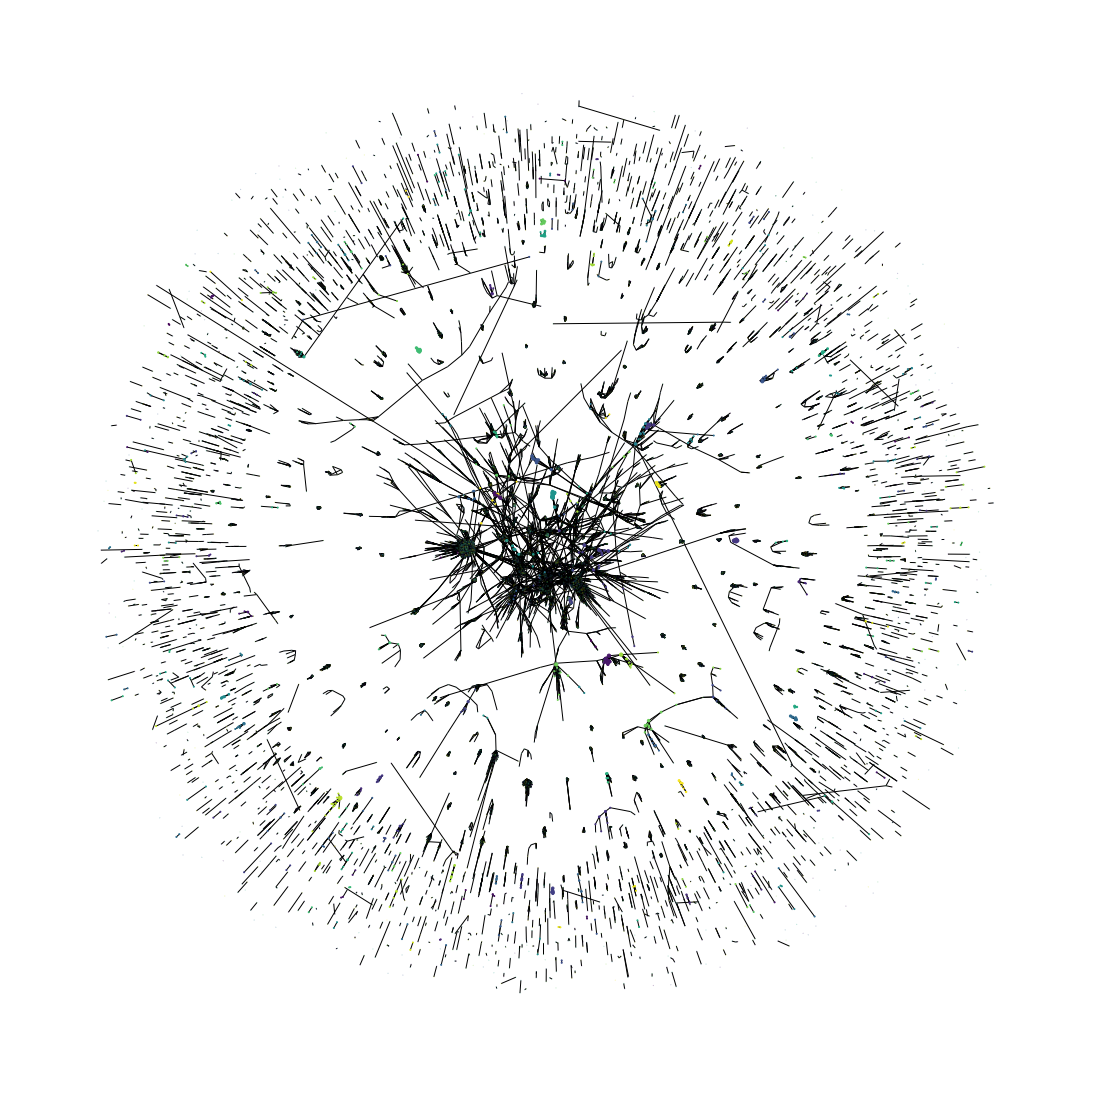

In [7]:
plt.figure(figsize = (15,15))
nx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],
    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])
plt.savefig('start.svg')

Graph with 11870 nodes and 19683 edges
[[5882.4409214 ]
 [5858.31808551]
 [5845.68932147]
 [5839.15096349]
 [5833.45212321]
 [5829.92390318]
 [5826.24422415]
 [5823.44293584]
 [5820.56295371]
 [5818.04149167]
 [5815.52256164]
 [5813.14649271]
 [5810.80587833]
 [5808.51580263]
 [5806.26898212]
 [5804.03240782]
 [5801.83687104]
 [5799.63427646]
 [5797.46721944]
 [5795.28636498]
 [5793.1349855 ]
 [5790.96802518]
 [5788.82493515]
 [5786.66677932]
 [5784.52767126]
 [5782.37500485]
 [5780.23738914]
 [5778.0880621 ]
 [5775.95054885]
 [5773.8031878 ]
 [5771.66506228]
 [5769.51881768]
 [5767.37978212]
 [5765.23416042]
 [5763.09417368]
 [5760.94892417]
 [5758.80810076]
 [5756.66313817]
 [5754.52168419]
 [5752.37703516]
 [5750.23520743]
 [5748.09097322]
 [5745.9490533 ]
 [5743.80538369]
 [5741.66366148]
 [5739.52073637]
 [5737.37949989]
 [5735.23751648]
 [5733.09704574]]


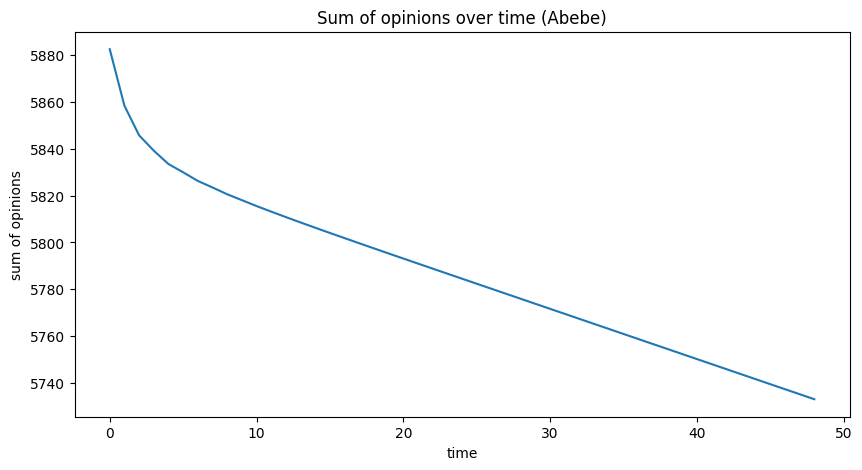

In [40]:
test = ExperimentClass(g_simple, 'Abebe')
test.run_model(5)
test.plot()

In [16]:
from read_networks import read_combined_graph_from_csv, read_citation_graph_from_edgelist

def create_graph():
    np.random.seed(42)
    # create random graph
    # g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
    #g = read_citation_graph_from_edgelist (field='History', graph=nx.Graph())
    g_simple, g_init, df = read_combined_graph_from_csv(field='History', init_cutoff_date = '2019-03-31', graph=nx.Graph())
    print(g_simple)
    print(g_init)
    # add node properties such as weight and opinion

    for node in g_simple.nodes:
        g_simple.nodes[node]['opinion'] = 0

    # Initialize with a given timpstamp.
    # If nodes are connected before this timestamp, they share a same init opinion.
    for node in g_simple.nodes:
        has_opinion_flag = False
        for init_nbr in g_init.neighbors(node):
            if g_simple.nodes[init_nbr]['opinion'] != 0:
                g_simple.nodes[node]['opinion'] = g_simple.nodes[init_nbr]['opinion']
                has_opinion_flag = True
                break
        if not has_opinion_flag:
            # use gaussian distribution
            g_simple.nodes[node]['opinion'] = np.random.normal(0.5, 0.1)
        # print(g_simple.nodes[node]['opinion'])

        g_simple.nodes[node]['conformity'] = np.random.uniform(0, 1)
        g_simple.nodes[node]['node_centrality'] = 0.01 + g_init.degree(node) # approx by citations
    

    # add edge weight
    for e1, e2 in g_simple.edges:
        g_simple.edges[e1, e2]['weight'] = np.random.rand()
        # g_simple.edges[e1, e2]['weight'] = np.random.rand()
    
    return g_simple

# # display thier properties
# for node in g.nodes:
#     print(g.nodes[node])

In [17]:
import plotly.graph_objects as go
mode = ['Abebe', 'new']
fig = go.Figure()
test_graph = create_graph()
for i in mode:
    graph = test_graph.copy()
    print(graph.nodes[node]['conformity'])
    test = ExperimentClass(graph, i)
    test.run_model(10)
    avgdiff_per_iter = test.get_avgdiff_per_iter()
    print(avgdiff_per_iter)
    fig.add_trace(go.Scatter(x=np.arange(1, len(avgdiff_per_iter)+1), y=avgdiff_per_iter, mode='lines', name=f'{i}'))
fig.update_layout(title=f'Opinions difference over time', 
                  xaxis_title='step', yaxis_title='Avg difference in opinions',
                  title_x=0.5, title_y=0.85,
                  legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="right",
                    x=0.99
                  ),
                  width=600, height=400)
# update x ticks to every 1
fig.update_xaxes(dtick=1)
fig.update_layout
fig.show()

Graph with 11870 nodes and 19683 edges
Graph with 11870 nodes and 943 edges
0.45252472422271883
Graph with 11870 nodes and 19683 edges
[0.05122163233788494, 0.018277269664580178, 0.009224975924183311, 0.005960304056529076, 0.004128954097192372, 0.0031375451430261064, 0.002466909943659252, 0.002031057279062384, 0.0017060144382832268]
0.45252472422271883
Graph with 11870 nodes and 19683 edges
[0.060118578499118246, 0.025150861470090068, 0.017252331722421237, 0.013767712874762764, 0.011799878622279249, 0.010427752029671344, 0.009418722028007432, 0.008609507946799868, 0.007942849058562402]


## Interate Component

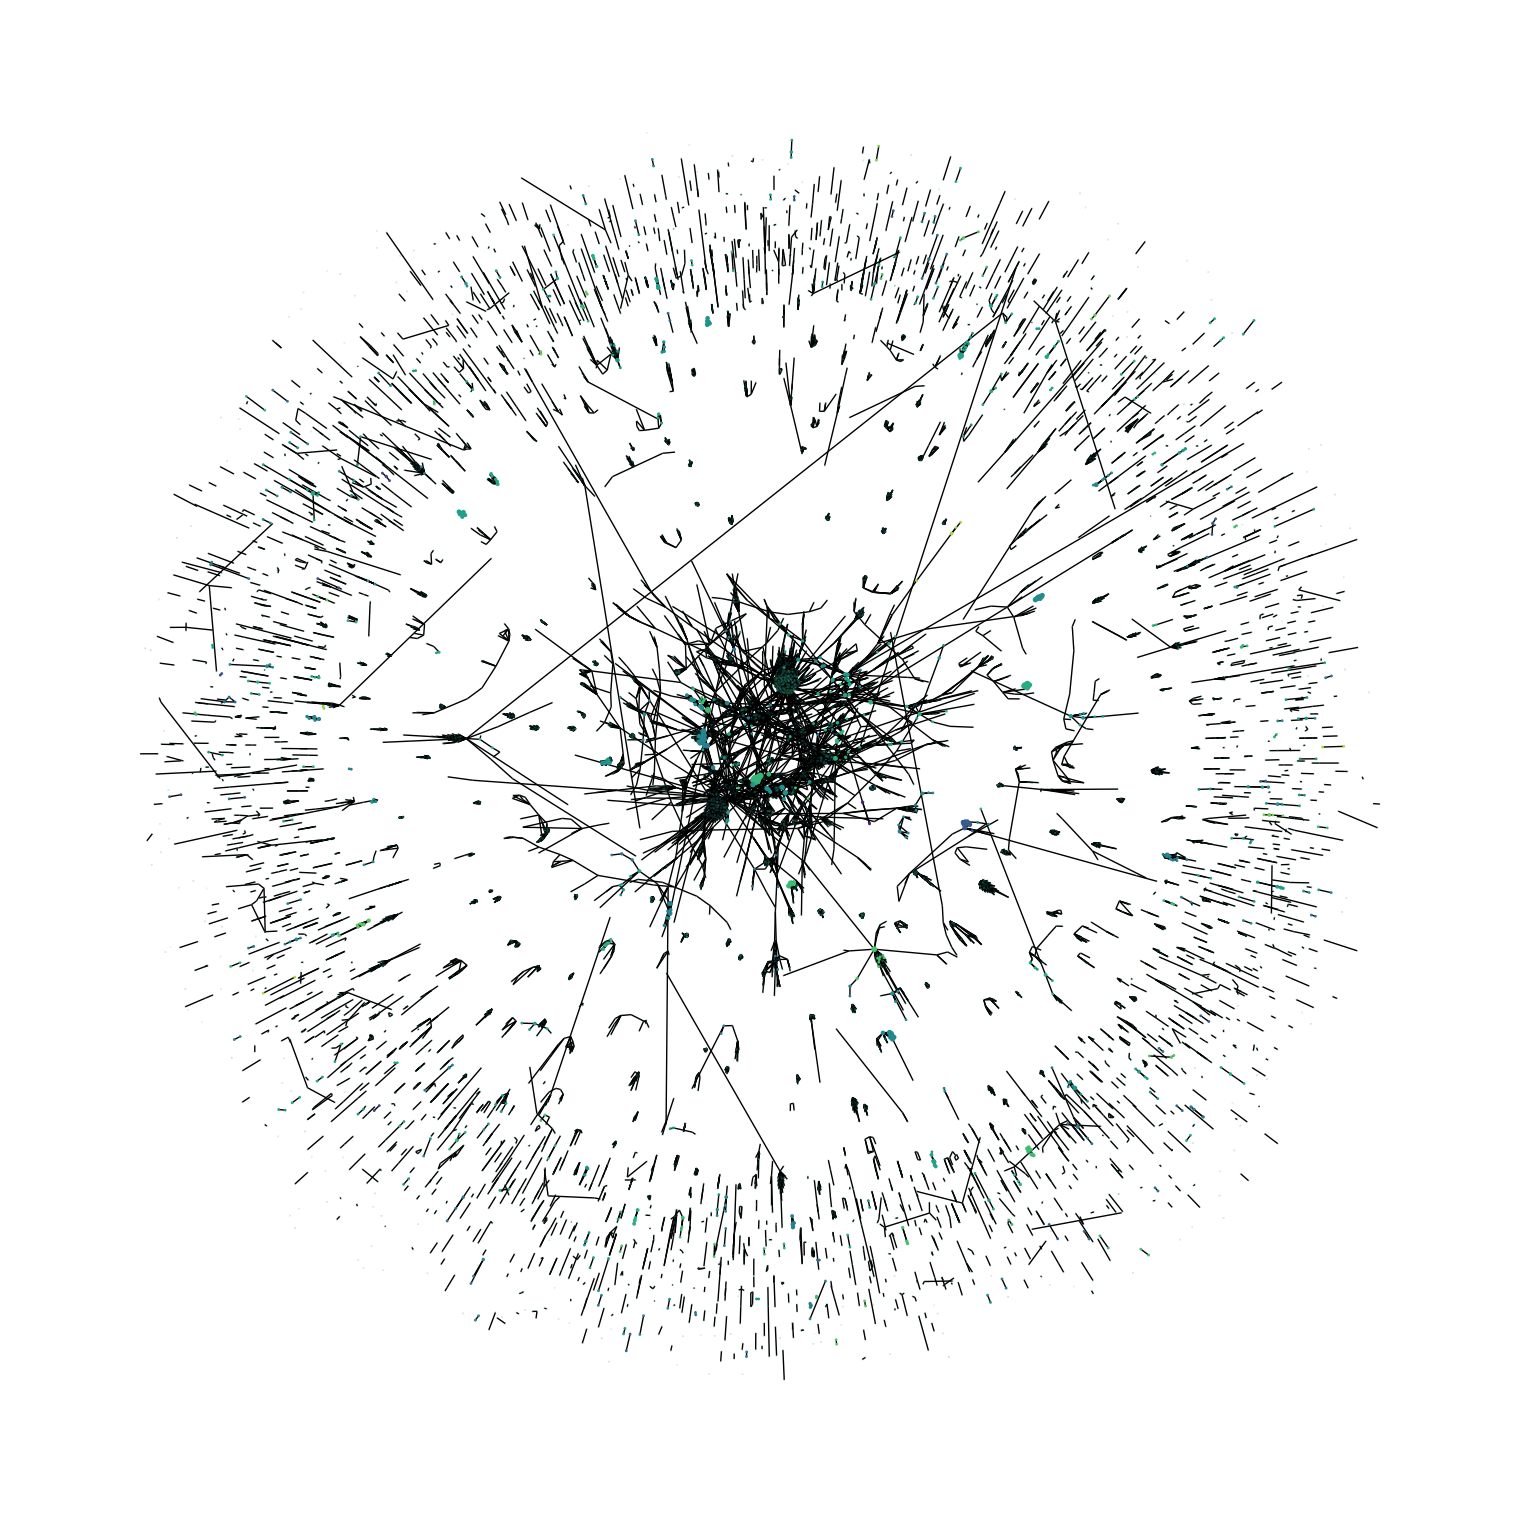

In [18]:
plt.figure(figsize = (15,15))
g_simple = test_graph.copy()


In [49]:
list(nx.connected_components(g_simple))
for i in list(nx.connected_components(g_simple)):
    if len(i) == 20:
        subgraph = i
        break

In [67]:
pos = nx.spring_layout(g_simple)

Graph with 11870 nodes and 19683 edges


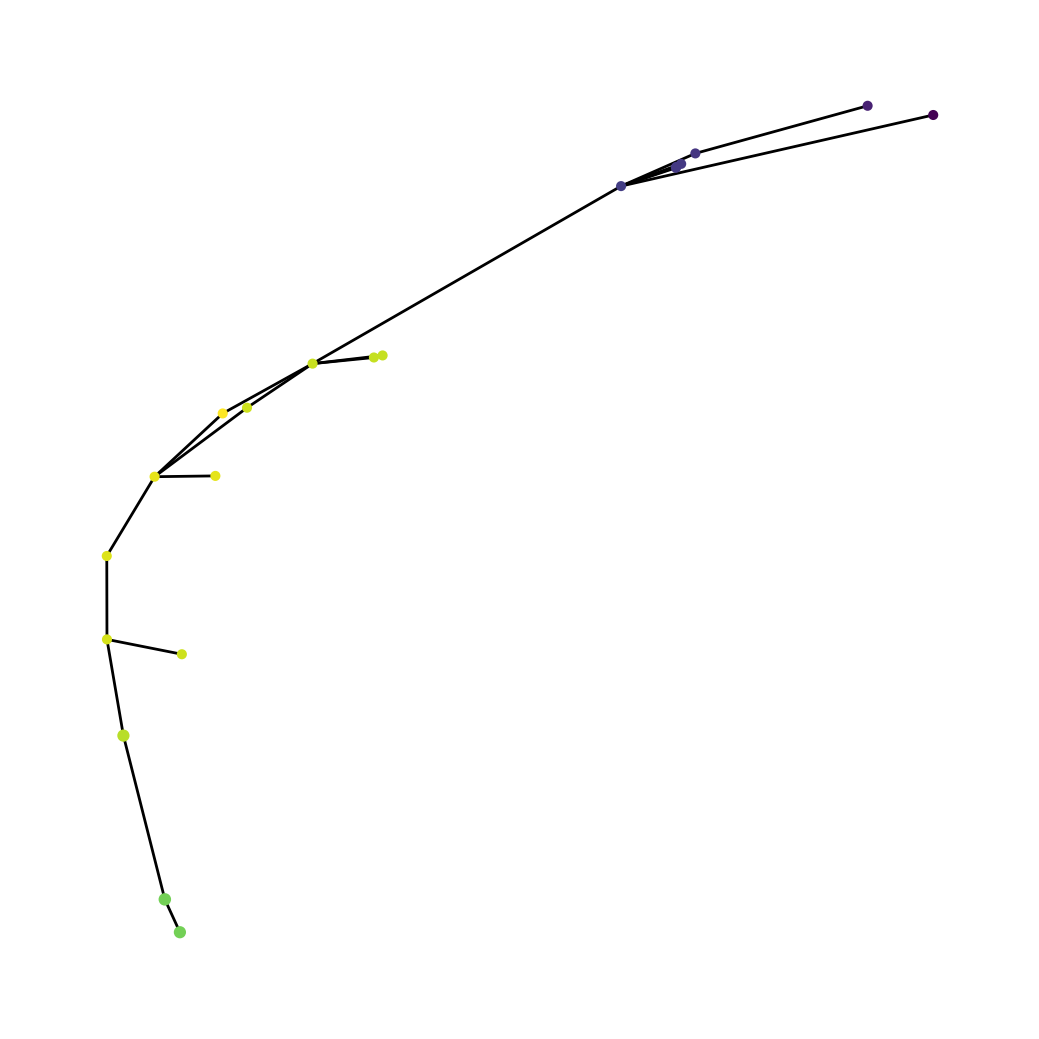

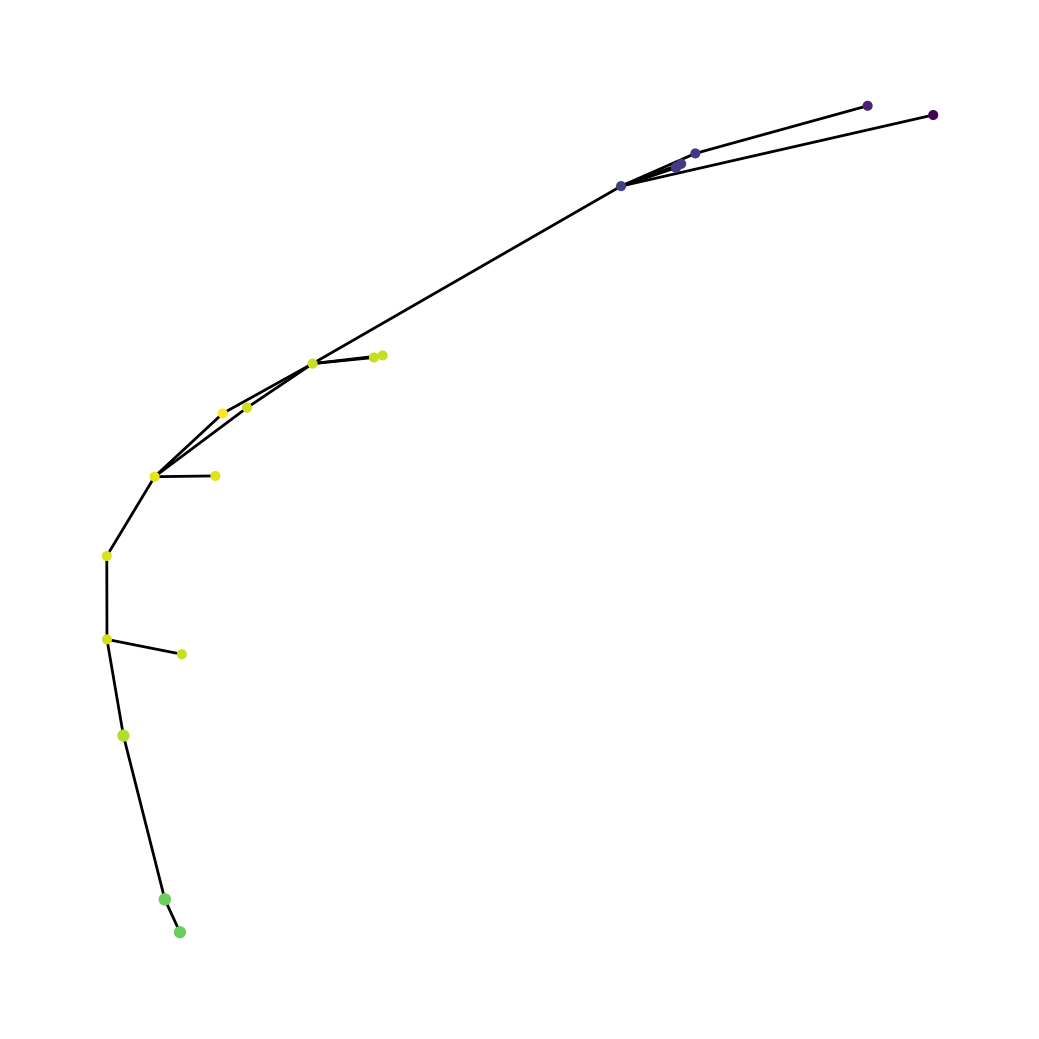

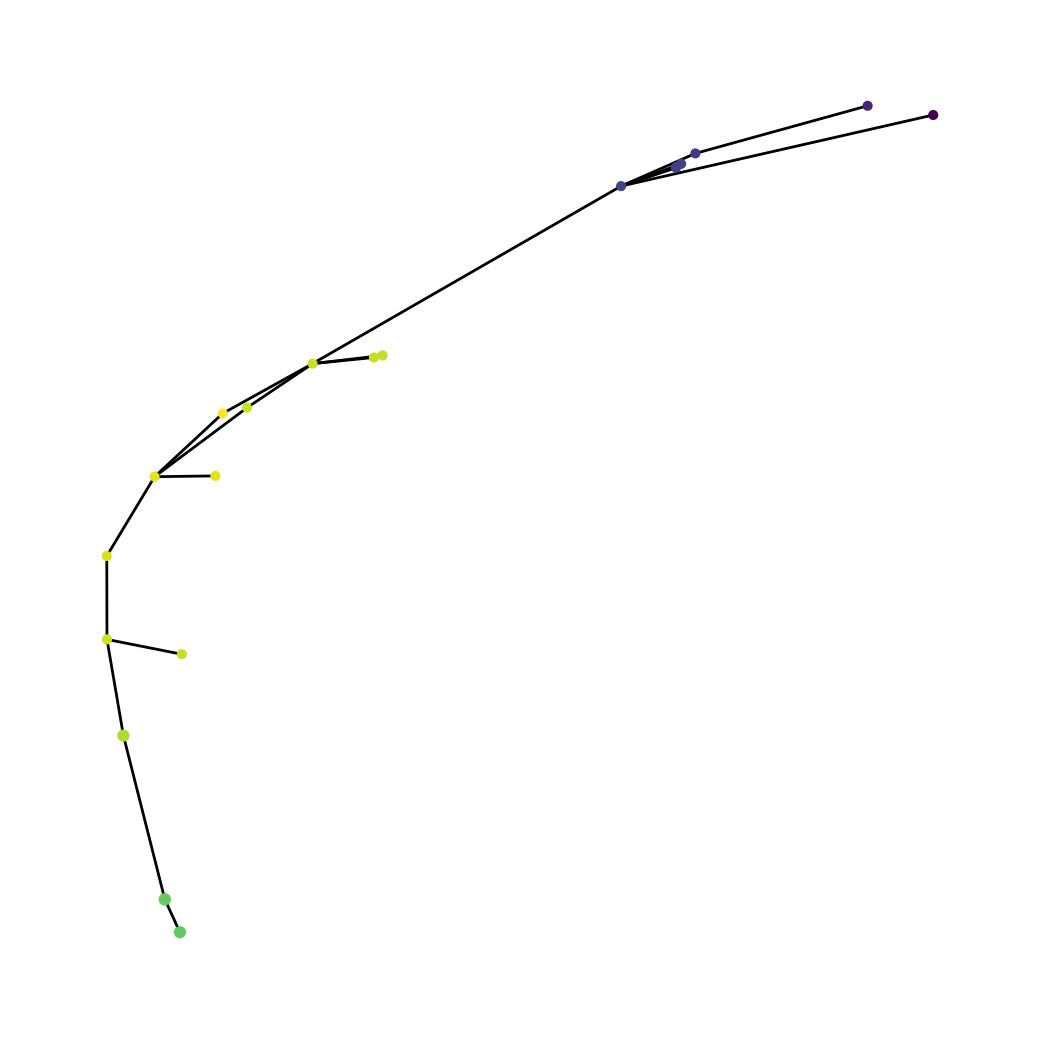

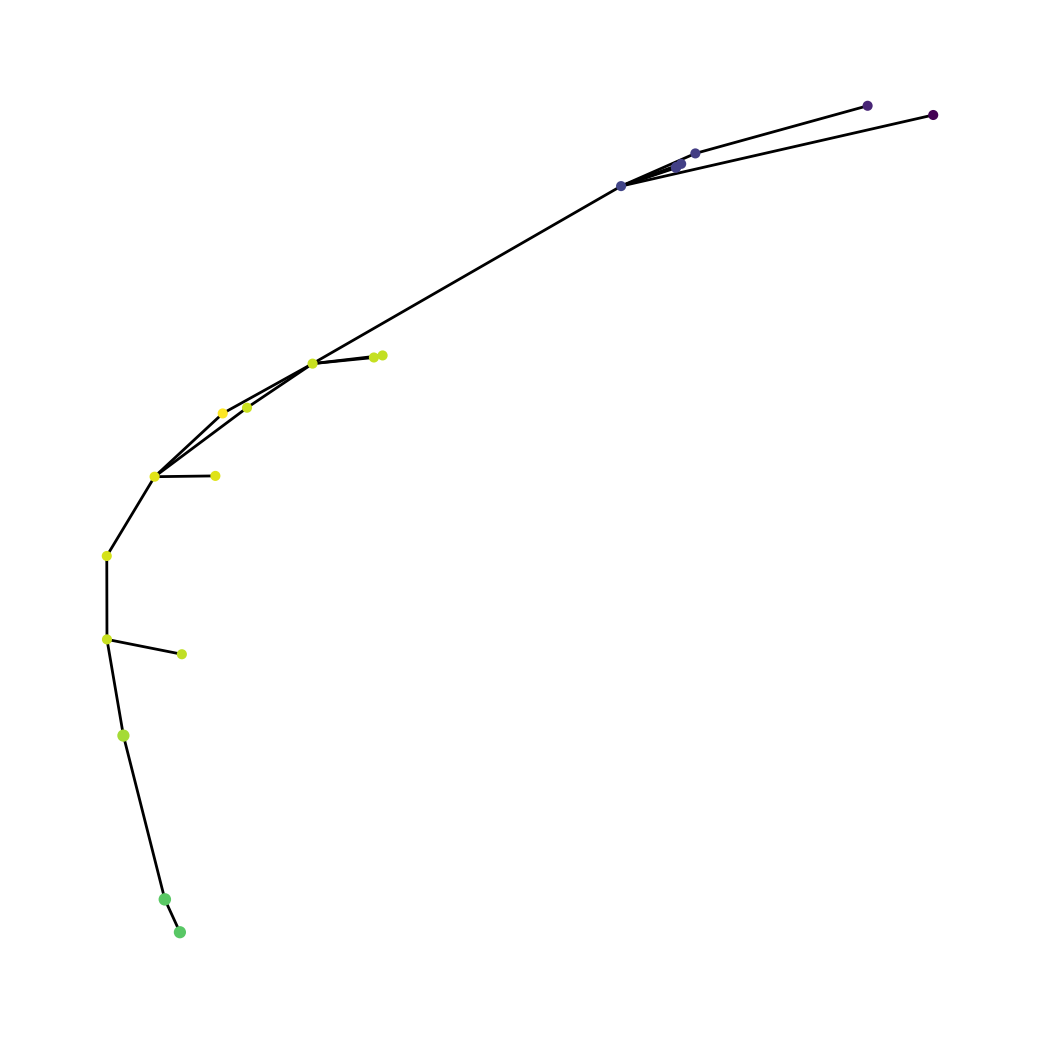

In [71]:
cnt = 0
%config InlineBackend.figure_format = 'retina'
test = ExperimentClass(g_simple, 'Abebe')
while cnt < 4:
    test.run_model(20)
    # draw subgraph of g_simple
    plt.figure(figsize=(5, 5))
    node_sizes = [np.log(g_simple.nodes[node]['node_centrality']*100000) for node in g_simple.subgraph(subgraph).nodes]
    node_colors = [g_simple.nodes[node]['opinion'] for node in g_simple.subgraph(subgraph).nodes]
    # always draw the nodes in the same place
    nx.draw(g_simple.subgraph(subgraph), pos=pos, node_size=node_sizes, node_color=node_colors)
    cnt += 1
